In [1]:
import pandas as pd
import json
import os
import regex as re

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-37dafe05-eb30-4982-a6b1-89f3bccf97a2;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 437ms :: artifacts dl 13ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/10 19:26:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [5]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df_subs = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df_subs is None:
        df_subs = month_df
    else:
        df_subs = df_subs.union(month_df)

23/11/10 19:26:29 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


23/11/10 19:26:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
CPU times: user 23.1 ms, sys: 2.42 ms, total: 25.5 ms
Wall time: 20.4 s


In [6]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/comments" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df_comms = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df_comms is None:
        df_comms = month_df
    else:
        df_comms = df_comms.union(month_df)

CPU times: user 10.5 ms, sys: 7.63 ms, total: 18.1 ms
Wall time: 7.34 s


In [7]:
df_comms.select(['subreddit', 'author', 'body', 'parent_id', 'link_id', 'id', 'created_utc', 'controversiality']).show(10)

+-----------------+--------------------+--------------------+----------+---------+-------+-------------------+----------------+
|        subreddit|              author|                body| parent_id|  link_id|     id|        created_utc|controversiality|
+-----------------+--------------------+--------------------+----------+---------+-------+-------------------+----------------+
|    AmItheAsshole|         beckydragon|                 NTA| t3_rz9uu3|t3_rz9uu3|hs0rusg|2022-01-10 04:49:57|               0|
|    AmItheAsshole|        Cactus_chuck|NTA. My partners ...| t3_s0baev|t3_s0baev|hs0rusr|2022-01-10 04:49:57|               0|
|    AmItheAsshole|   Red-belliedOrator|INFO\n\nIn genera...| t3_s0a5hn|t3_s0a5hn|hs0rut9|2022-01-10 04:49:57|               0|
|NoStupidQuestions|  SoMuchForLongevity|You couldn't heat...| t3_s0b5be|t3_s0b5be|hs0rutc|2022-01-10 04:49:57|               0|
|NoStupidQuestions|          MMmason651|it wouldn't taste...| t3_s0axsd|t3_s0axsd|hs0rutm|2022-01-10 04:

In [8]:
df_comms.select('controversiality').distinct().show(5)

+----------------+
|controversiality|
+----------------+
|               0|
|               1|
+----------------+



In [9]:
df_comms.select('author', 'body', 'controversiality', 'score').show(5)

+------------------+--------------------+----------------+-----+
|            author|                body|controversiality|score|
+------------------+--------------------+----------------+-----+
|       beckydragon|                 NTA|               0|    1|
|      Cactus_chuck|NTA. My partners ...|               0|    3|
| Red-belliedOrator|INFO\n\nIn genera...|               0|    1|
|SoMuchForLongevity|You couldn't heat...|               0|    2|
|        MMmason651|it wouldn't taste...|               0|    1|
+------------------+--------------------+----------------+-----+
only showing top 5 rows



In [10]:
from pyspark.sql.functions import avg, stddev, max, min, count

# Group by controversiality and calculate statistics for score
df_stats = df_comms.groupBy("controversiality").agg(
    count("score").alias("count"),
    avg("score").alias("average_score"),
    stddev("score").alias("stddev_score"),
    max("score").alias("max_score"),
    min("score").alias("min_score")
)

# Show the results
df_stats.show()


+----------------+--------+------------------+-----------------+---------+---------+
|controversiality|   count|     average_score|     stddev_score|max_score|min_score|
+----------------+--------+------------------+-----------------+---------+---------+
|               0|74390792|17.771784214906596|280.1505133689703|    96210|   -15345|
|               1| 2112571|0.9712416766111056|44.60361843268679|    39797|     -855|
+----------------+--------+------------------+-----------------+---------+---------+



In [11]:
pandas_df_stats = df_stats.toPandas()

In [12]:
#below showed me that comments are considered controversial when there is a certian ratio of up and down votes

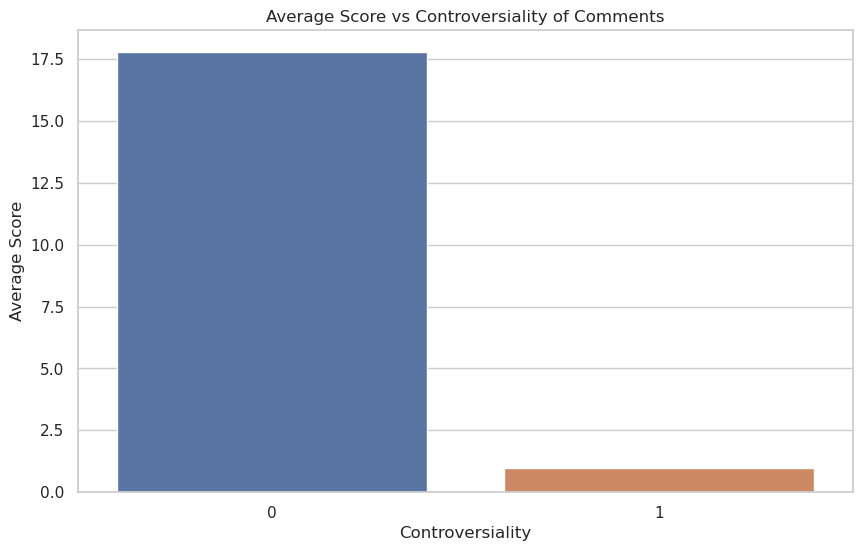

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for average score vs controversiality
plt.figure(figsize=(10, 6))
sns.barplot(x="controversiality", y="average_score", data=pandas_df_stats)

# Add labels and title
plt.xlabel("Controversiality")
plt.ylabel("Average Score")
plt.title("Average Score vs Controversiality of Comments")

# Show the plot
plt.show()


In [14]:
from pyspark.sql.functions import sum

# Group by controversiality and calculate the total gildings for each group
df_gilded_stats = df_comms.groupBy("controversiality").agg(
    sum("gilded").alias("total_gildings")
)

# Convert to Pandas DataFrame
pandas_df_gilded_stats = df_gilded_stats.toPandas()


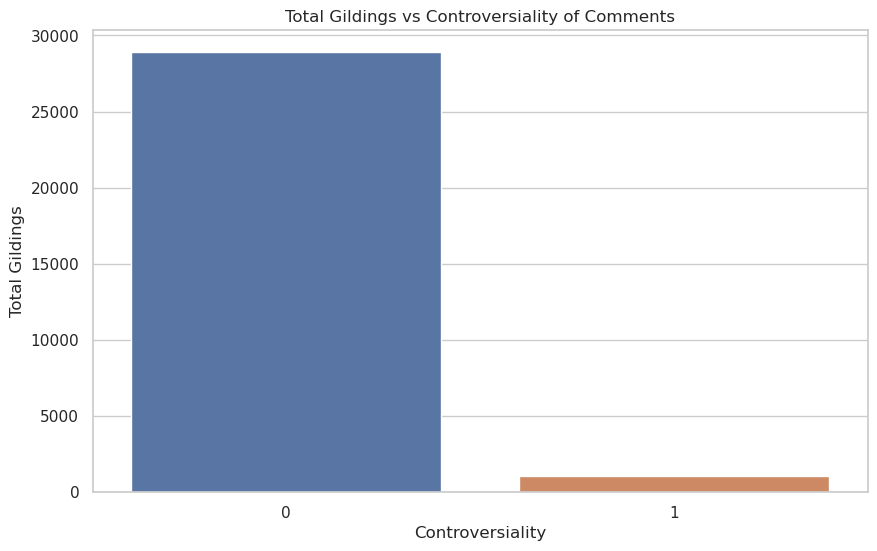

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for total gildings vs controversiality
plt.figure(figsize=(10, 6))
sns.barplot(x="controversiality", y="total_gildings", data=pandas_df_gilded_stats)

# Add labels and title
plt.xlabel("Controversiality")
plt.ylabel("Total Gildings")
plt.title("Total Gildings vs Controversiality of Comments")

# Show the plot
plt.show()


In [18]:
from pyspark.sql.functions import col, sum

# Group by controversiality and count the stickied comments
# Cast the boolean 'stickied' column to an integer for summation
df_stickied_stats = df_comms.groupBy("controversiality").agg(
    sum(col("stickied").cast("int")).alias("total_stickied")
)

# Convert to Pandas DataFrame for visualization
pandas_df_stickied_stats = df_stickied_stats.toPandas()


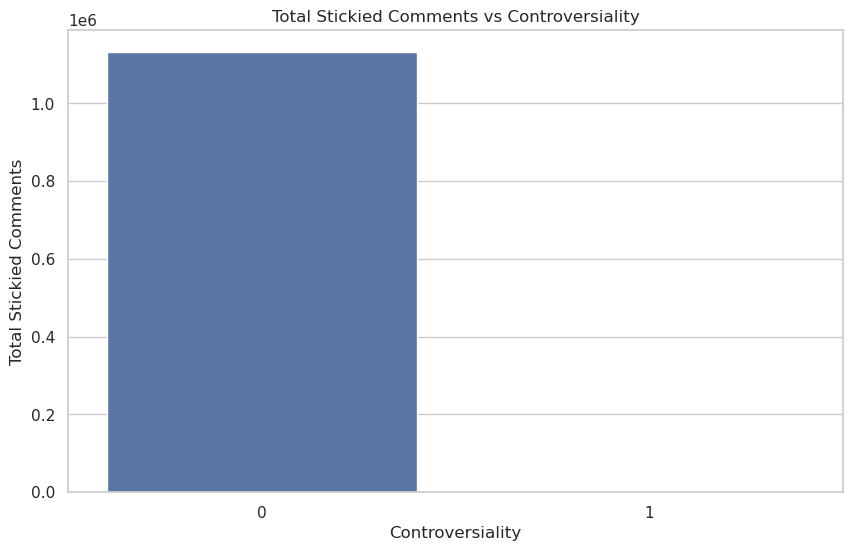

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for total stickied comments vs controversiality
plt.figure(figsize=(10, 6))
sns.barplot(x="controversiality", y="total_stickied", data=pandas_df_stickied_stats)

# Add labels and title
plt.xlabel("Controversiality")
plt.ylabel("Total Stickied Comments")
plt.title("Total Stickied Comments vs Controversiality")

# Show the plot
plt.show()


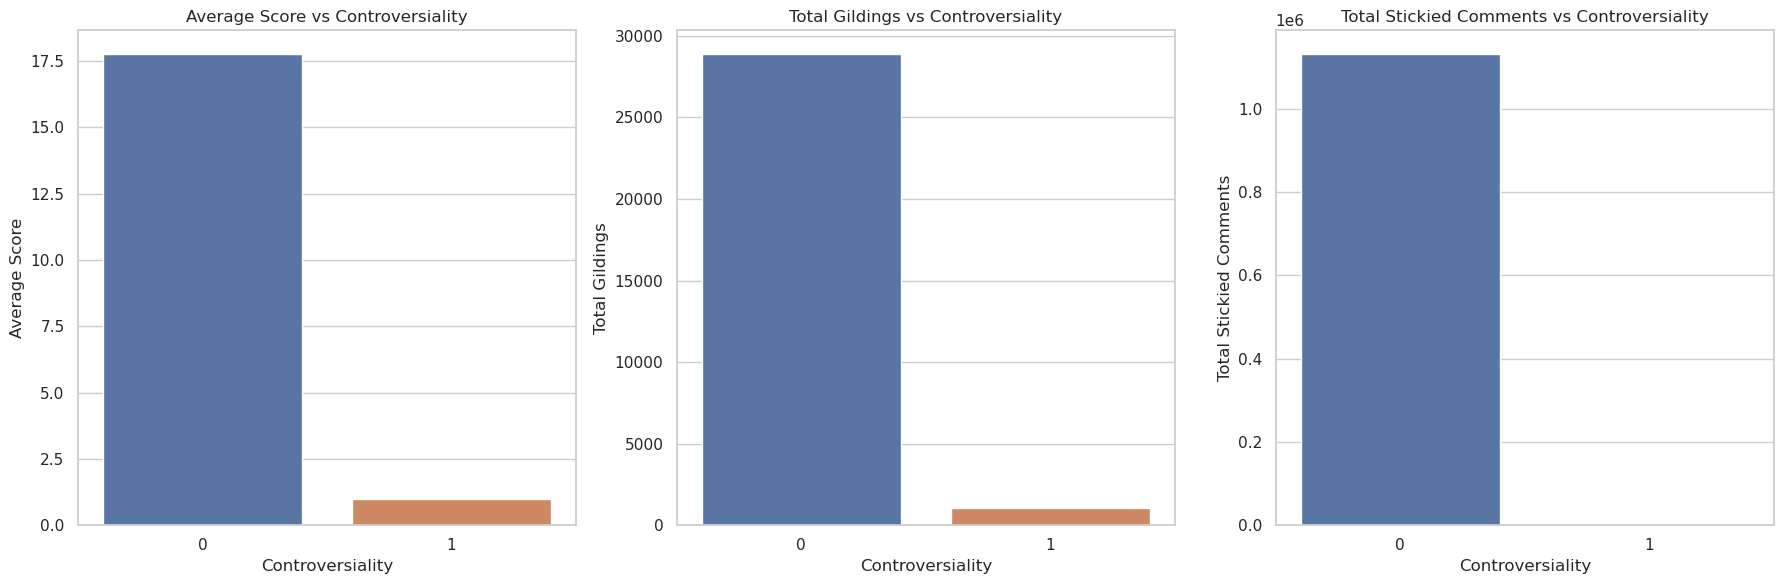

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# style 
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot average score
sns.barplot(x="controversiality", y="average_score", data=pandas_df_stats, ax=axes[0])
axes[0].set_title('Average Score vs Controversiality')
axes[0].set_xlabel('Controversiality')
axes[0].set_ylabel('Average Score')

# Plt total gildings
sns.barplot(x="controversiality", y="total_gildings", data=pandas_df_gilded_stats, ax=axes[1])
axes[1].set_title('Total Gildings vs Controversiality')
axes[1].set_xlabel('Controversiality')
axes[1].set_ylabel('Total Gildings')

# Plot stickied comments
sns.barplot(x="controversiality", y="total_stickied", data=pandas_df_stickied_stats, ax=axes[2])
axes[2].set_title('Total Stickied Comments vs Controversiality')
axes[2].set_xlabel('Controversiality')
axes[2].set_ylabel('Total Stickied Comments')

# Display 
plt.tight_layout()

fig.savefig('../website-source/img/engagement-comparison.png')

plt.show()

In [21]:
#code for processing data was adapted with assistance from ChatGPT